In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [99]:
import numpy as np
import pandas as pd

def generate_pseudo_sigmoid_data(
    num_batches=10,
    total_points=1000,
    plateau_size=150,
    infection_point=0.5,
    noise_level=0.02,
    steepness=10,
    random_infection=False,
    random_noise=False,
    random_seed=None,
    data_point_scale=5,
    max_value=7,
    outlier_fraction=0.1,
    outlier_infection_point_deviation=0.1,
    outlier_steepness_deviation=2
):
    """
    Generate multiple batches of pseudo-sigmoidal curves with some batches being mild outliers.
    Noise level remains consistent across all batches.

    Parameters:
    - num_batches (int): Number of batches to generate.
    - total_points (int): Total number of data points per batch.
    - plateau_size (int): Number of points in the starting and ending plateaus.
    - infection_point (float): Default inflection point (default 0.5).
    - noise_level (float): Default noise level (standard deviation) (default 0.02).
    - steepness (float): Steepness of the sigmoid (default 10).
    - random_infection (bool): If True, assign a random infection point to each batch.
    - random_noise (bool): If True, assign a random noise level to each batch.
    - random_seed (int or None): Seed for reproducibility.
    - data_point_scale (float): Upper limit for scaling data_point values (default 5).
    - max_value (float): Desired maximum value for the 'value' column (default 7).
    - outlier_fraction (float): Fraction of batches that are outliers (default 0.1).
    - outlier_infection_point_deviation (float): Deviation for infection point in outliers (default 0.1).
    - outlier_steepness_deviation (float): Deviation for steepness in outliers (default 2).

    Returns:
    - df_long (pandas.DataFrame): Long-format DataFrame with columns ['batch', 'data_point', 'value'].
    - df_metadata (pandas.DataFrame): DataFrame containing metadata for each batch.
    """

    if random_seed is not None:
        np.random.seed(random_seed)

    if plateau_size * 2 >= total_points:
        raise ValueError("Plateau size is too large for the total number of points.")
    if not (0 <= infection_point <= 1):
        raise ValueError("Infection point must be between 0 and 1.")

    # Precompute constants
    sigmoid_size = total_points - 2 * plateau_size
    x_base = np.linspace(0, 1, sigmoid_size)
    data_points_scaled = np.linspace(0, data_point_scale, total_points)

    data = []
    metadata = []
    outlier_batches = []

    # Determine number of outlier batches
    num_outliers = int(np.round(num_batches * outlier_fraction))

    # Randomly select which batches will be outliers
    batch_indices = np.arange(1, num_batches + 1)
    outlier_indices = np.random.choice(batch_indices, size=num_outliers, replace=False)

    for i in range(1, num_batches + 1):
        is_outlier = i in outlier_indices

        # Assign noise level (consistent across all batches)
        if random_noise:
            current_noise_level = np.random.uniform(0.01, 0.05)
        else:
            current_noise_level = noise_level

        # Set parameters for outlier or regular batch
        if is_outlier:
            # Outlier batches have adjusted infection point and steepness
            current_infection_point = infection_point + np.random.uniform(
                -outlier_infection_point_deviation, outlier_infection_point_deviation
            )
            current_steepness = steepness + np.random.uniform(
                -outlier_steepness_deviation, outlier_steepness_deviation
            )

            # Collect the batch name for outliers
            outlier_batches.append(f'Batch_{i}')
        else:
            # Use default or randomized parameters
            current_infection_point = (
                np.random.uniform(0.3, 0.7) if random_infection else infection_point
            )
            current_steepness = steepness

        # Ensure parameters are within valid ranges
        current_infection_point = np.clip(current_infection_point, 0, 1)
        current_steepness = max(current_steepness, 0.1)  # Prevent division by zero

        # Adjust x to place the inflection point at the desired infection_point
        x_shifted = x_base - current_infection_point

        # Compute the sigmoid
        sigmoid = 1 / (1 + np.exp(-current_steepness * x_shifted))

        # Initialize the full y array with plateaus and sigmoid
        y = np.concatenate([
            np.zeros(plateau_size),
            sigmoid,
            np.ones(plateau_size)
        ])

        # Add Gaussian noise and clip values to [0, 1]
        noise = np.random.normal(0, current_noise_level, total_points)
        y_noisy = np.clip(y + noise, 0, 1)

        # Scale curve to have desired max_value
        y_scaled = y_noisy / np.max(y_noisy) * max_value

        # Create a DataFrame for the current batch
        df_batch = pd.DataFrame({
            'batch': f'Batch_{i}',
            'data_point': data_points_scaled,
            'value': y_scaled
        })

        data.append(df_batch)

        # Store metadata
        metadata.append({
            'batch': f'Batch_{i}',
            'infection_point': current_infection_point,
            'noise_level': current_noise_level,
            'steepness': current_steepness,
            'plateau_size': plateau_size,
            'is_outlier': is_outlier
        })

    # Concatenate all batches into a single DataFrame
    df_long = pd.concat(data, ignore_index=True)

    # Create a metadata DataFrame
    df_metadata = pd.DataFrame(metadata)

    # Print the names of the outlier batches
    if outlier_batches:
        print("Outlier batches:")
        for batch_name in outlier_batches:
            print(batch_name)
    else:
        print("No outlier batches in this dataset.")

    return df_long, df_metadata


In [100]:
df_long, df_metadata = generate_pseudo_sigmoid_data(num_batches=20, random_seed=123)

Outlier batches:
Batch_6
Batch_15


In [101]:


def plot_batches_long(df_long, batches_to_plot=None, title='Pseudo Sigmoidal Batches', figsize=(12, 8)):
    """
    Plot multiple batches of pseudo-sigmoidal curves from a long-format DataFrame.

    Parameters:
    - df_long (pandas.DataFrame): Long-format DataFrame containing all batches to plot.
    - batches_to_plot (list or None): List of batch names to plot. If None, plots all batches.
    - title (str): Title of the plot.
    - figsize (tuple): Size of the figure.
    """
    plt.figure(figsize=figsize)

    if batches_to_plot is None:
        batches_to_plot = df_long['batch'].unique()

    for batch in batches_to_plot:
        batch_data = df_long[df_long['batch'] == batch]
        plt.plot(batch_data['data_point'], batch_data['value'], label=batch)

    plt.title(title)
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [102]:
def save_batches_to_csv(df_long, df_metadata, data_filename='pseudo_sigmoid_batches_long.csv',
                        metadata_filename='pseudo_sigmoid_batches_metadata.csv'):
    """
    Save the long-format batches and metadata to CSV files.

    Parameters:
    - df_long (pandas.DataFrame): Long-format DataFrame containing all batches.
    - df_metadata (pandas.DataFrame): DataFrame containing metadata for each batch.
    - data_filename (str): Filename for the data CSV.
    - metadata_filename (str): Filename for the metadata CSV.
    """
    df_long.to_csv(data_filename, index=False)
    df_metadata.to_csv(metadata_filename, index=False)
    print(f"Data saved to '{data_filename}' and metadata saved to '{metadata_filename}'.")

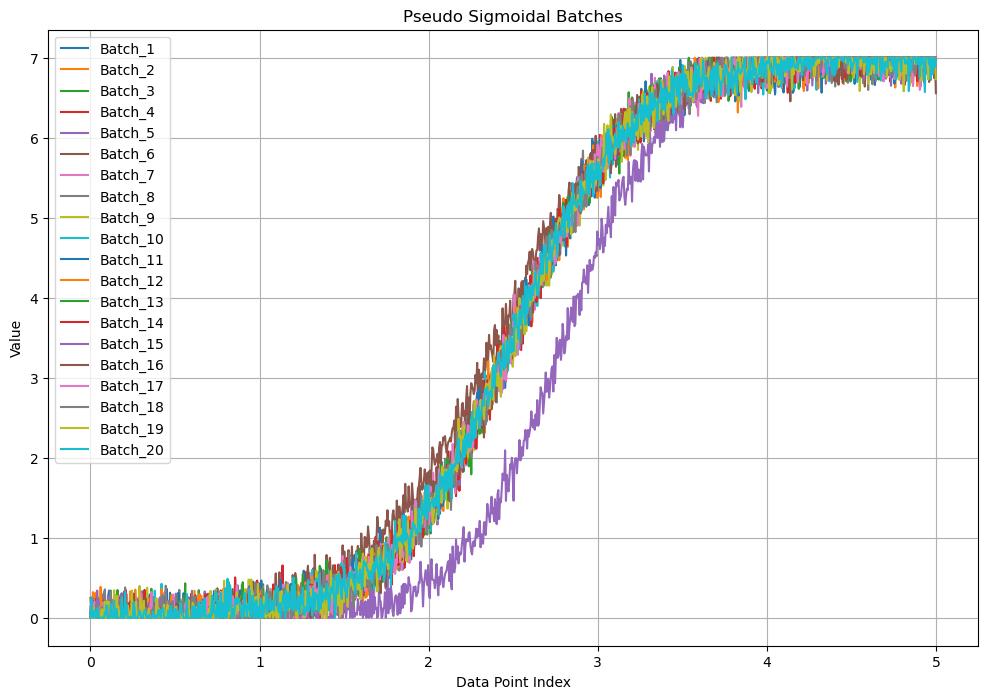

In [103]:
plot_batches_long(df_long)

In [104]:
save_batches_to_csv(df_long, df_metadata, data_filename='pseudo_sigmoid_batches_long.csv',
                        metadata_filename='pseudo_sigmoid_batches_metadata.csv')

Data saved to 'pseudo_sigmoid_batches_long.csv' and metadata saved to 'pseudo_sigmoid_batches_metadata.csv'.
